In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('/kaggle/input/train-indessa/train_indessa.csv')
test = pd.read_csv('/kaggle/input/test-indessa/test_indessa.csv')

In [3]:
for col in train.select_dtypes(include=[np.number]).columns:
    train[col].fillna(train[col].mean(), inplace=True)
for col in test.select_dtypes(include=[np.number]).columns:
    test[col].fillna(test[col].mean(), inplace=True)

In [4]:
categorical_cols = train.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    mode_value = train[col].mode()[0]
    train[col].fillna(mode_value, inplace=True)
    test[col].fillna(mode_value, inplace=True)
    le = LabelEncoder()
    combined_data = pd.concat([train[col], test[col]], axis=0)
    le.fit(combined_data)
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

In [5]:
train['total_payment'] = train['loan_amnt'] + train['funded_amnt'] + train['funded_amnt_inv']
test['total_payment'] = test['loan_amnt'] + test['funded_amnt'] + test['funded_amnt_inv']

In [6]:
train['income_to_loan_ratio'] = train['annual_inc'] / train['loan_amnt']
test['income_to_loan_ratio'] = test['annual_inc'] / test['loan_amnt']

In [7]:
train['dti_revol_util'] = train['dti'] * train['revol_util'].fillna(0)
test['dti_revol_util'] = test['dti'] * test['revol_util'].fillna(0)

In [8]:
train['total_recovery'] = train['recoveries'] + train['total_rec_int']
test['total_recovery'] = test['recoveries'] + test['total_rec_int']

In [9]:
train['balance_to_credit_ratio'] = train['tot_cur_bal'] / train['total_rev_hi_lim']
test['balance_to_credit_ratio'] = test['tot_cur_bal'] / test['total_rev_hi_lim']

In [10]:
train['recoveries_to_balance_ratio'] = train['recoveries'] / (train['tot_cur_bal'] + 1)
test['recoveries_to_balance_ratio'] = test['recoveries'] / (test['tot_cur_bal'] + 1)

In [11]:
train['batch_enrolled_to_total_rec_int'] = train['batch_enrolled'] / (train['total_rec_int'] + 1)
test['batch_enrolled_to_total_rec_int'] = test['batch_enrolled'] / (test['total_rec_int'] + 1)

In [12]:
train['loan_amnt_total_rec_int_ratio'] = train['loan_amnt'] / (train['total_rec_int'] + 1)
test['loan_amnt_total_rec_int_ratio'] = test['loan_amnt'] / (test['total_rec_int'] + 1)

In [13]:
train['emp_length_missing'] = train['emp_length'].isnull().astype(int)
test['emp_length_missing'] = test['emp_length'].isnull().astype(int)

In [14]:
columns_to_drop = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'annual_inc', 'emp_title',
    'home_ownership', 'purpose', 'grade', 'sub_grade', 'desc', 'title', 'zip_code',
    'addr_state', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
    'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
    'total_rec_late_fee', 'collection_recovery_fee', 'collections_12_mths_ex_med',
    'mths_since_last_major_derog', 'verification_status_joint', 'acc_now_delinq',
    'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'
]

In [15]:
train = train.drop(columns=columns_to_drop, errors='ignore')
test = test.drop(columns=columns_to_drop, errors='ignore')

In [16]:
final_columns = [
    'total_payment', 'income_to_loan_ratio', 'dti_revol_util',
    'total_recovery', 'balance_to_credit_ratio', 'recoveries_to_balance_ratio',
    'batch_enrolled_to_total_rec_int', 'loan_amnt_total_rec_int_ratio',
    'emp_length_missing'
]

In [17]:
train = train[final_columns + ['loan_status']]
test_features = test[final_columns]

In [18]:
def handle_infinity(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)

handle_infinity(train)
handle_infinity(test_features)

In [19]:
train['loan_status'] = LabelEncoder().fit_transform(train['loan_status'])

X = train.drop(columns=['loan_status'])
y = train['loan_status']

In [20]:
X = train.drop(columns=['loan_status'])
y = train['loan_status']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
print("Class distribution before SMOTE:", y_train.value_counts())

Class distribution before SMOTE: loan_status
0    325172
1    100770
Name: count, dtype: int64


In [23]:
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [24]:
print("Class distribution after SMOTE:", y_train_smote.value_counts())

Class distribution after SMOTE: loan_status
0    325172
1    325172
Name: count, dtype: int64


In [25]:
X_train_smote_df = pd.DataFrame(X_train_smote, columns=X.columns)
y_train_smote_df = pd.DataFrame(y_train_smote, columns=['loan_status'])
train_smote_df = pd.concat([X_train_smote_df, y_train_smote_df], axis=1)
train_smote_reduced = train_smote_df.groupby('loan_status').apply(lambda x: resample(x, n_samples=int(len(x)*0.25), random_state=42)).reset_index(drop=True)

In [26]:
X_train_reduced = train_smote_reduced.drop(columns=['loan_status'])
y_train_reduced = train_smote_reduced['loan_status']

In [27]:
print("Class distribution after SMOTE:", y_train_reduced.value_counts())

Class distribution after SMOTE: loan_status
0    81293
1    81293
Name: count, dtype: int64


In [28]:
scaler = StandardScaler()
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test = scaler.transform(X_test)

In [29]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # ROC Curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Print metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

    return accuracy, precision, recall, f1


In [30]:
def perform_grid_search(model, param_grid, X_train, y_train, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    return grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


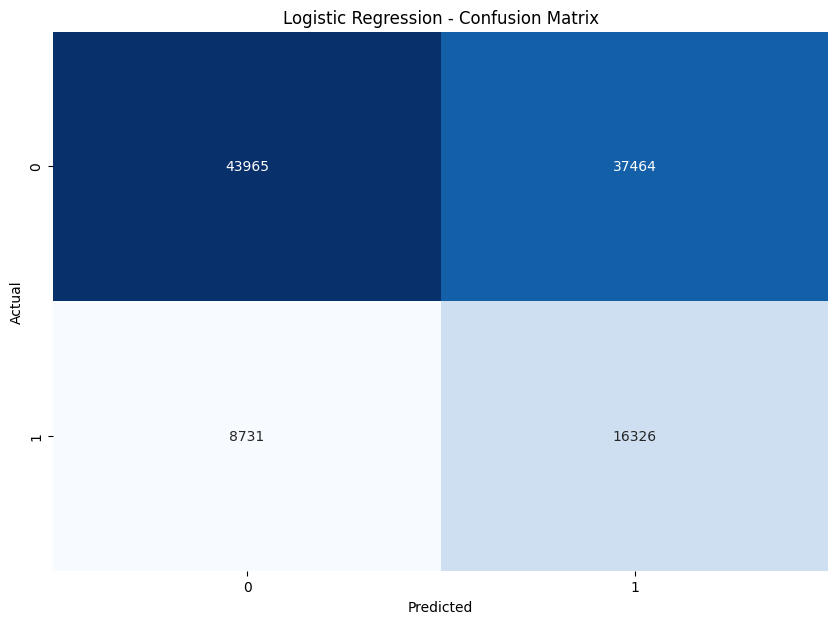

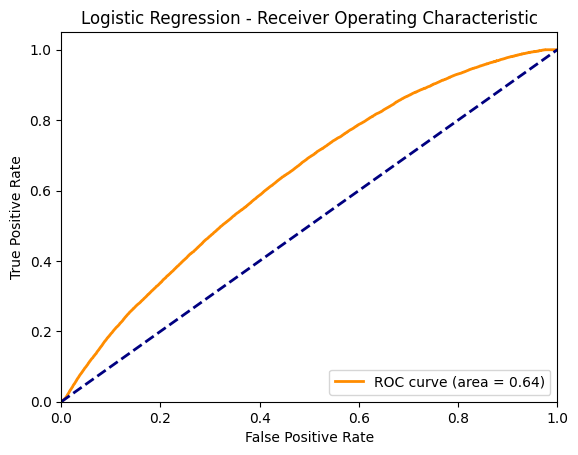

Logistic Regression Metrics:
Accuracy: 0.5662
Precision: 0.7094
Recall: 0.5662
F1 Score: 0.5988



(0.5661871044080912,
 0.7094123199095798,
 0.5661871044080912,
 0.5987640863989468)

In [31]:
logistic_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}
logistic_model = perform_grid_search(LogisticRegression(max_iter=1000), logistic_params, X_train_reduced, y_train_reduced, "Logistic Regression")
logistic_model.fit(X_train_reduced, y_train_reduced)
evaluate_model(logistic_model, X_test, y_test, "Logistic Regression")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END max_depth=10, min_samples_split=2, n_estimators=500; total time= 3.5min
[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time= 1.4min
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=  42.9s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=  42.1s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=  42.7s
[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time= 1.4min
[CV] END max_depth=10, min_samples_split=10, n_estimators=500; total time= 3.6min
[CV] END max_depth=20, min_samples_split=2,

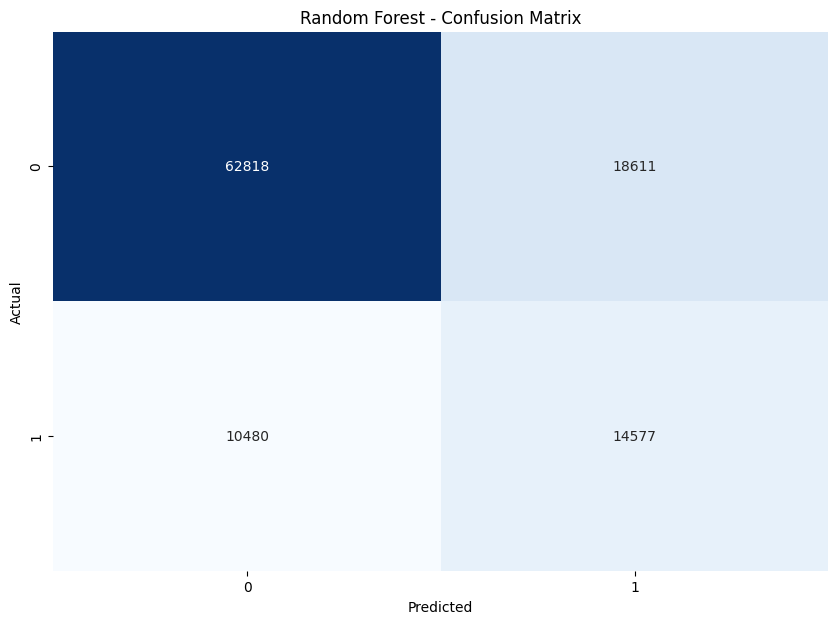

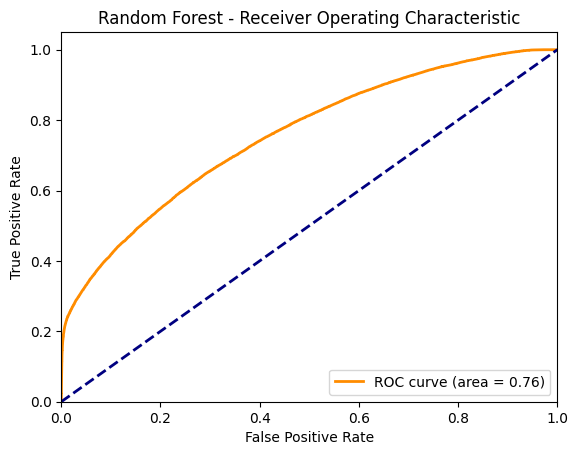

Random Forest Metrics:
Accuracy: 0.7268
Precision: 0.7587
Recall: 0.7268
F1 Score: 0.7387



(0.7268091580113818, 0.7587110737156548, 0.7268091580113818, 0.738699699835835)

In [32]:
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_model = perform_grid_search(RandomForestClassifier(), rf_params, X_train_reduced, y_train_reduced, "Random Forest")
rf_model.fit(X_train_reduced, y_train_reduced)
evaluate_model(rf_model, X_test, y_test, "Random Forest")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  55.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 1.8min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 1.5min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 1.5min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time= 3.0min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=500; total time= 7.4min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 4.1min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  55.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  55.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  55.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time= 1.8min
[CV] END ...learning_rate=0.1, max_depth=3, n_es

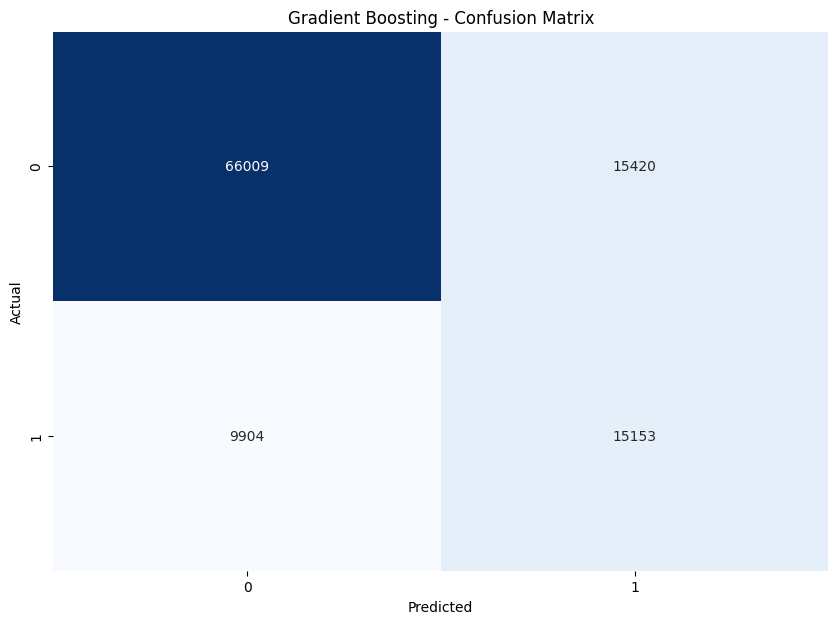

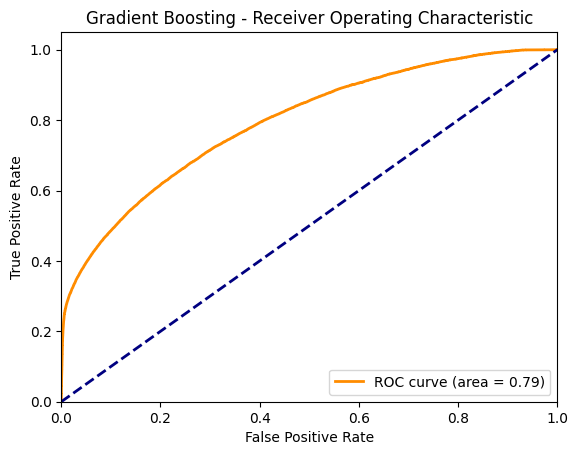

Gradient Boosting Metrics:
Accuracy: 0.7622
Precision: 0.7816
Recall: 0.7622
F1 Score: 0.7698



(0.7621847003361945,
 0.7815528844615017,
 0.7621847003361945,
 0.7698064121037844)

In [33]:
gb_params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_model = perform_grid_search(GradientBoostingClassifier(), gb_params, X_train_reduced, y_train_reduced, "Gradient Boosting")
gb_model.fit(X_train_reduced, y_train_reduced)
evaluate_model(gb_model, X_test, y_test, "Gradient Boosting")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500}


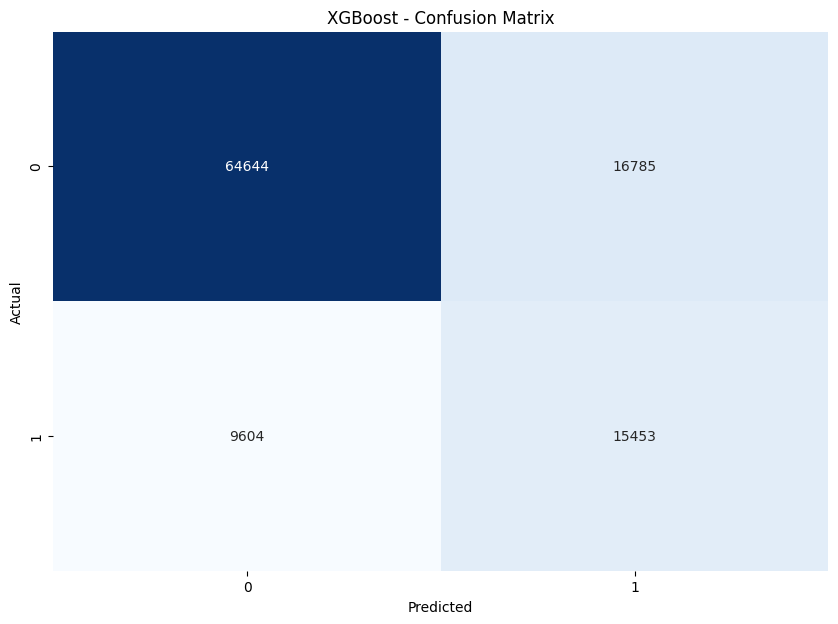

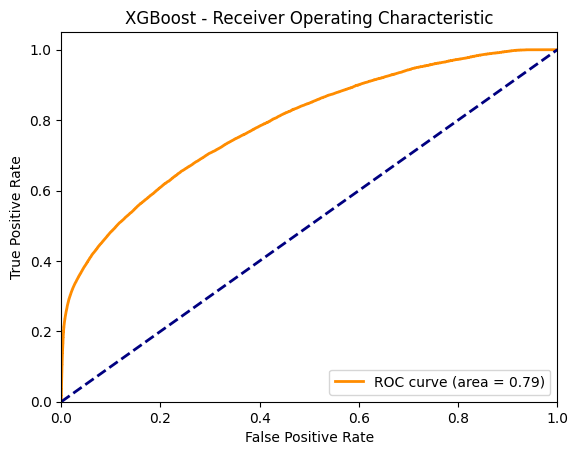

XGBoost Metrics:
Accuracy: 0.7522
Precision: 0.7786
Recall: 0.7522
F1 Score: 0.7620



(0.7521833856093759, 0.7785717070794169, 0.7521833856093759, 0.761997696699387)

In [34]:
xgb_params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
xgb_model = perform_grid_search(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), xgb_params, X_train_reduced, y_train_reduced, "XGBoost")
xgb_model.fit(X_train_reduced, y_train_reduced)
evaluate_model(xgb_model, X_test, y_test, "XGBoost")

In [35]:
best_logistic = logistic_model
best_rf = rf_model
best_gb = gb_model
best_xgb=xgb_model

In [36]:
import os

In [37]:
output_path = '/kaggle/working/'

In [38]:
joblib.dump(best_logistic, os.path.join(output_path, 'best_logistic_model.joblib'))
joblib.dump(best_rf, os.path.join(output_path, 'best_rf_model.joblib'))
joblib.dump(best_gb, os.path.join(output_path, 'best_gb_model.joblib'))
joblib.dump(best_xgb, os.path.join(output_path, 'best_xgb_model.joblib'))

['/kaggle/working/best_xgb_model.joblib']

In [39]:
def plot_metrics(metric_name, metrics, models):
    plt.figure(figsize=(8, 6))
    plt.bar(models, metrics)
    plt.title(f'{metric_name} Comparison')
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.show()

In [40]:
accuracies = []
precisions = []
recalls = []
f1_scores = []
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']  # Add 'XGBoost' to the models list

# Example model predictions (replace with your actual model predictions)
logistic_pred = best_logistic.predict(X_test)
rf_pred = best_rf.predict(X_test)
gb_pred = best_gb.predict(X_test)
xgb_pred = best_xgb.predict(X_test)  # XGBoost predictions

# Logistic Regression metrics
accuracies.append(accuracy_score(y_test, logistic_pred))
precisions.append(precision_score(y_test, logistic_pred))
recalls.append(recall_score(y_test, logistic_pred))
f1_scores.append(f1_score(y_test, logistic_pred))

# Random Forest metrics
accuracies.append(accuracy_score(y_test, rf_pred))
precisions.append(precision_score(y_test, rf_pred))
recalls.append(recall_score(y_test, rf_pred))
f1_scores.append(f1_score(y_test, rf_pred))

# Gradient Boosting metrics
accuracies.append(accuracy_score(y_test, gb_pred))
precisions.append(precision_score(y_test, gb_pred))
recalls.append(recall_score(y_test, gb_pred))
f1_scores.append(f1_score(y_test, gb_pred))

# XGBoost metrics
accuracies.append(accuracy_score(y_test, xgb_pred))
precisions.append(precision_score(y_test, xgb_pred))
recalls.append(recall_score(y_test, xgb_pred))
f1_scores.append(f1_score(y_test, xgb_pred))

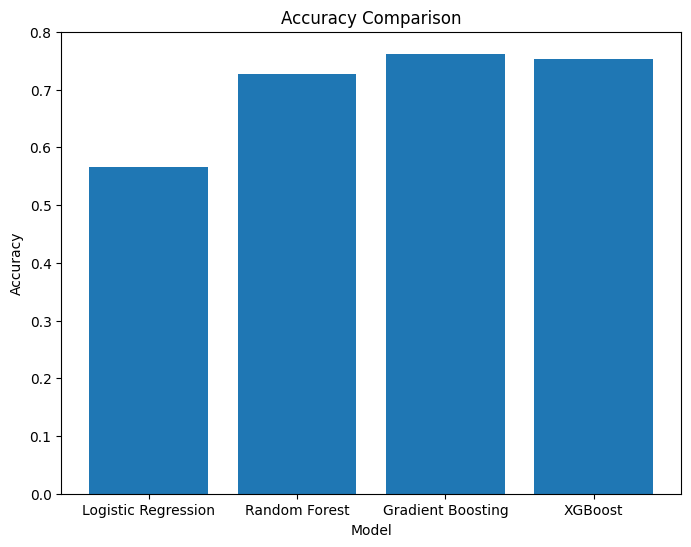

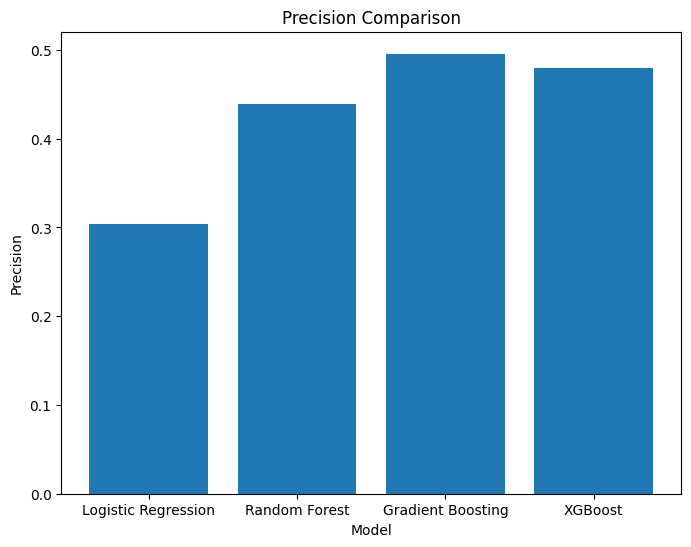

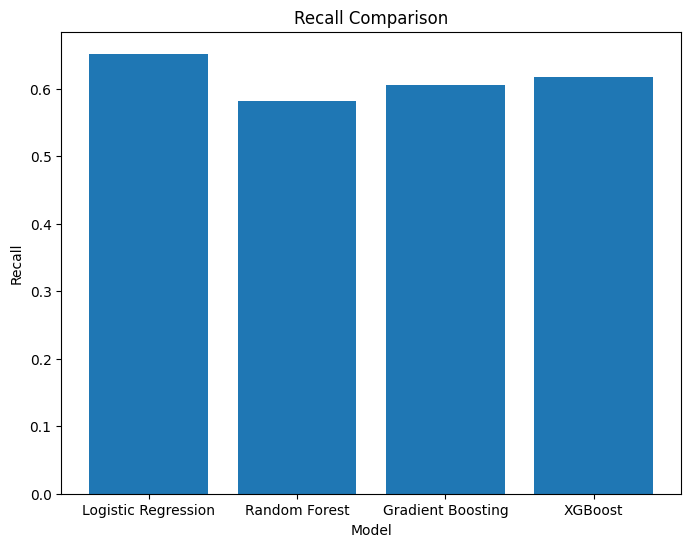

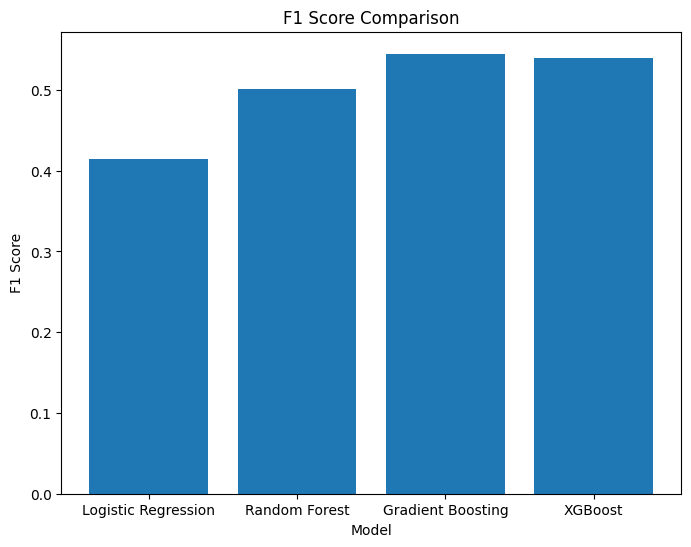

In [41]:
plot_metrics('Accuracy', accuracies, models)
plot_metrics('Precision', precisions, models)
plot_metrics('Recall', recalls, models)
plot_metrics('F1 Score', f1_scores, models)